## 7.2.1 RVM for regression

目标变量t的条件概率分布为:
$$p(t|x,w\beta)=\mathcal N(t|y(x),\beta^{-1})$$
均值由线性模型给出:$$y(x)=w^T\phi(x)$$
写成SVM相类似的形式:
$$y(x)=\sum_{n=1}^Nw_nk(x,x_n)+b$$
参数的数量为$M = N + 1$,$y(x)$与SVM的预测模型具有相同的形式,与SVM的情形相反，没有正定核的限制，基函数也没有被训练数据点的数量或位置所限制。

似然函数为:
$$p(t|X,w,\beta)=\prod^N_{n=1}p(t_n|x_n,w,\beta)$$
引入w的先验分布，为每一个$w_i$,都引入一个超参数$\alpha_i$(ard先验):
$$p(w|\alpha)=\prod_{i=1}^N\mathcal N(w_i|0,\alpha_i^{-1})$$
当我们关于这些超参数
最⼤化模型证据时，⼤部分都趋于⽆穷，对应的权参数的后验概率分布集中在零附近,⽣成了⼀个稀疏的模型。
w的后验分布为:$$p(w|t,X,\alpha,\beta)=\mathcal N(w|m,\Sigma)$$
均值为:$$m=\beta\Sigma\Phi^Tt$$
方差为:$$\Sigma=(A+\beta\Phi^T\Phi)^{-1}$$

$\Phi$是NxM的设计矩阵，
元素为$\Phi_{ni}=\phi_i(x_n)(i=1,...,N),\Phi_{nM}=1(n=1,...,N),A=diag(\alpha_{i})$

边缘似然函数为:
$$p(t|X,\alpha,\beta)=\int p(t|X,w,\beta)p(w|\alpha)dw$$
对数边缘似然函数为:
$$\begin{align}lnp(t|X,\alpha,\beta)&=ln\mathcal N(t|0,C)\\
&=-\frac{1}{2}\{Nln(2\pi)+ln|c|+t^TC^{-1}t\}\end{align}$$
其中C为NXN矩阵:
$$C=\beta^{-1}I+\Phi A^{-1}\Phi^T$$

关于超参数$\alpha$,$\beta$最大化边缘似然函数得到$\alpha^*,\beta^*$
现在要关于$\alpha$和$\beta$最大化对数边缘似然函数，采用类似线性模型中的证据近似方法
* $$\alpha_i^{new}=\frac{\gamma_i}{m_i^2}$$
* $$(\beta^{new})^{-1}=\frac{\lVert t-\Phi m\lVert^2}{N-\sum_i\gamma_i}$$

其中$m_i$是后验均值$m$的第i个分量，$\gamma_i=1-\alpha_i\sum_{ii}$

预测分布为:
$$\begin{align}p(t|x,X,t,\alpha^*,\beta^*)&=\int p(t|x,w,\beta*)p(w|X,t,\alpha^*,\beta^*)dw\\&=\mathcal N(t|m^T\phi(x),\sigma^2(x))\end{align}$$

w为后验均值m,方差为$\sigma^2(x)=(\beta^*)^{-1}+\phi(x)^T\sigma\phi(x)$

RVM中先关向量的数量⽐SVM中使⽤的⽀持向量的数量少得多。对于⼀⼤类回归任务和分类任务， RVM⽣成的模型通常⽐对应的⽀持向量机⽣成的模型简洁了⼀个数量级,与SVM相⽐，这种稀疏性的增⼤并没有减⼩泛化误差。
虽然RVM的设计对矩阵求逆,时间复杂度为$O(M^3)$，高于SVM($O(N^2)$)，但是控制模型复杂度的参数以及噪声方差自动由一次训练过程确定，不需要交叉验证

In [1]:
import sys
sys.path.append(r"../")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prml.kernel import (
    RBF,
    PolynomialKernel,
    SupportVectorClassifier,
    RelevanceVectorRegressor,
    RelevanceVectorClassifier
)

np.random.seed(1234)

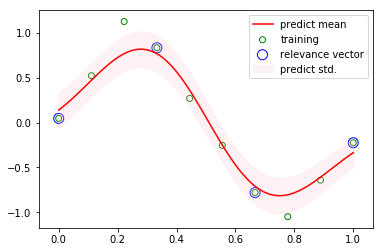

In [2]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)
    t = np.sin(2 * np.pi * x) + np.random.normal(scale=0.1, size=n)
    return x, t

x_train, y_train = create_toy_data(n=10)
x = np.linspace(0, 1, 100)

model = RelevanceVectorRegressor(RBF(np.array([1., 20.])))
model.fit(x_train, y_train)

y, y_std = model.predict(x)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="g", label="training")
plt.scatter(model.X.ravel(), model.t, s=100, facecolor="none", edgecolor="b", label="relevance vector")
plt.plot(x, y, color="r", label="predict mean")
plt.fill_between(x, y - y_std, y + y_std, color="pink", alpha=0.2, label="predict std.")
plt.legend(loc="best")
plt.show()

## 7.2.3 RVM for classifying

回到第4章的二分类模型
$$y(x,w)=\sigma(w^T\phi(x))$$
在RVM中，模型使⽤的是ARD先验，其中每个权值参数有⼀个独⽴的精度超参数。
w后验概率分布为:
$$\begin{align}lnp(w|t,\alpha)&=ln{p(t|w)p(w|\alpha)}-lnp(t|\alpha)\\
&=\sum_{n=1}^N{t_nlny_n+(1-t_n)ln(1-y_n)}-\frac{1}{2}w^TAw+const\end{align}$$

由第4章的IRLS方法有:
$$\nabla  lnp(w|t,\alpha)=\Phi^T(t-y)-AW$$
$$\nabla\nabla lnp(w|t,\alpha)=-(\Phi^TB\Phi+A)$$
后验概率的⾼斯近似的众数，对应于⾼斯近似的均值
$$ w^*=A^{-1}\Phi^T（t-y)$$
$$ \Sigma=(\Phi^TB\Phi+A)^{-1}$$

拉普拉斯近似来计算边缘似然函数:
$$p(t|\alpha)=\int p(t|w)p(w|\alpha)dw\simeq p(t|w^*)p(w^*|\alpha)(2\pi)^{\frac{M}{2}}|\Sigma|^{\frac{1}{2}}$$

对$\alpha_i$求导令其为0解出:
$$\alpha_i^{new}=\frac{\gamma_i}{(w_i^*)^2}$$
这个形式和RVM回归时的形式一样，再把近似的对数似然函数写成:
$$lnp(t|\alpha)=-\frac{1}{2}{Nln(2\pi)+ln|C|+(\hat t)……{-1}^TC^{-1}(\hat t)}$$
其中$\hat t=\Phi w*+B^{-1}(t-y)$

$$ C=B+\Phi A^{-1} \Phi^T$$
参数更新的方法与RVM回归也一样